In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, r2_score, mean_squared_error
from  comprendre_api.Clean_donnees import liste_propre
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb


In [4]:
data = pd.concat([liste_propre(code_commune=None, taille_echantillon=10000)],
                axis=0, 
                ignore_index=True)
data.head(2)

,_id,consommation_energie,classe_consommation_energie,estimation_ges,surface_thermique_lot,classe_estimation_ges,annee_construction,tr002_type_batiment_description,code_insee_commune_actualise,geo_adresse,consommation_surface_ratio
0,WRYV9xQCjLUgZ4MAK3wKu,132.0,3.0,29.0,190.0,4.0,5200.0,Maison Individuelle,01430,3 Impasse du Foyer Rural 01160 Varambon,0.694737
1,y54XQHgRuWB5L1wiVTGJ4,221.0,4.0,3.0,78.2,1.0,2006.0,Logement,05120,Rue de la Bluette 05460 Abriès-Ristolas,2.826087


In [5]:
data.shape

(4415, 11)

In [6]:
data.isna().sum()

_id                                0
consommation_energie               0
classe_consommation_energie        0
estimation_ges                     0
surface_thermique_lot              0
classe_estimation_ges              0
annee_construction                 0
tr002_type_batiment_description    0
code_insee_commune_actualise       0
geo_adresse                        0
consommation_surface_ratio         0
dtype: int64

In [7]:
data.dropna(inplace=True)
data.shape

(4415, 11)

In [8]:
data['geo_adresse'].value_counts()

geo_adresse
Rue du Général de Gaulle (Pont) Saint-Sébastien-sur-Loire    19
Hameau des Rossignols 16000 Angoulême                        14
11bis Rue des Vannes 10800 Saint-Julien-les-Villas           13
1 Rue de la République 10150 Creney-près-Troyes              11
15 Rue Dainville 49000 Angers                                10
                                                             ..
2 Chemin des Corvées 10150 Lavau                              1
Rue Sainte Radegonde 14400 Subles                             1
10 Rue Marie Marvingt 15000 Aurillac                          1
Impasse du Puits 16220 Rouzède                                1
le champ des granges 16120 Mosnac-Saint-Simeux                1
Name: count, Length: 3975, dtype: int64

In [9]:
duplicate_rows = data.duplicated(keep='first')

# Display rows with duplicates
duplicates_df = data[duplicate_rows]
print("Duplicate Rows:")
print(duplicates_df)

# Count the number of duplicates
num_duplicates = duplicate_rows.sum()
print(f"Number of Duplicate Rows: {num_duplicates}")

Duplicate Rows:
Empty DataFrame
Columns: [_id, consommation_energie, classe_consommation_energie, estimation_ges, surface_thermique_lot, classe_estimation_ges, annee_construction, tr002_type_batiment_description, code_insee_commune_actualise, geo_adresse, consommation_surface_ratio]
Index: []
Number of Duplicate Rows: 0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4415 entries, 0 to 4414
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _id                              4415 non-null   object 
 1   consommation_energie             4415 non-null   float64
 2   classe_consommation_energie      4415 non-null   float64
 3   estimation_ges                   4415 non-null   float64
 4   surface_thermique_lot            4415 non-null   float64
 5   classe_estimation_ges            4415 non-null   float64
 6   annee_construction               4415 non-null   float64
 7   tr002_type_batiment_description  4415 non-null   object 
 8   code_insee_commune_actualise     4415 non-null   object 
 9   geo_adresse                      4415 non-null   object 
 10  consommation_surface_ratio       4415 non-null   float64
dtypes: float64(7), object(4)
memory usage: 379.5+ KB


In [11]:
data['departement']=data['code_insee_commune_actualise'].astype(str).str[:2]
data['departement'] = data['departement'].apply(lambda x: int(x) if x.isnumeric() else int(x[0]))

In [12]:
encoder = OneHotEncoder(sparse=False, drop='first')
building_type_encoded = pd.DataFrame(
    encoder.fit_transform(data[['tr002_type_batiment_description']]), 
    columns=encoder.get_feature_names_out(['tr002_type_batiment_description'])
    )
data_reg = pd.concat([data, building_type_encoded], axis=1)

zip_code_encoded = pd.DataFrame(
    encoder.fit_transform(data_reg[['departement']]), 
    columns=encoder.get_feature_names_out(['departement'])
    )
data_reg = pd.concat([data_reg, zip_code_encoded], axis=1)

# Step 2: Drop the original zip_code column
data_reg  = data_reg .drop(['tr002_type_batiment_description',
                            'code_insee_commune_actualise',
                            'geo_adresse',
                            '_id',
                            'departement'], 
                            axis=1)

data_reg.head(2)


/Users/eudeslocqueville/Documents/ENSAE/M1_S1/PYTHON/projet_python/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/eudeslocqueville/Documents/ENSAE/M1_S1/PYTHON/projet_python/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,consommation_energie,classe_consommation_energie,estimation_ges,surface_thermique_lot,classe_estimation_ges,annee_construction,consommation_surface_ratio,tr002_type_batiment_description_Logement,tr002_type_batiment_description_Maison Individuelle,departement_2,...,departement_86,departement_87,departement_88,departement_89,departement_90,departement_91,departement_92,departement_93,departement_94,departement_95
0,132.0,3.0,29.0,190.0,4.0,5200.0,0.694737,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,221.0,4.0,3.0,78.2,1.0,2006.0,2.826087,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X = data_reg.drop('classe_consommation_energie', axis=1)
y = data_reg['classe_consommation_energie']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3532, 102), (883, 102), (3532,), (883,))

In [14]:
model = xgb.XGBRegressor()

In [15]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

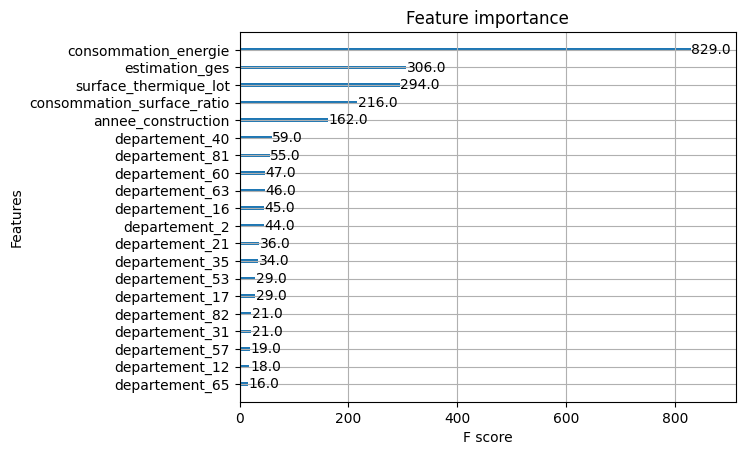

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

xgb.plot_importance(model, ax=plt.gca(), max_num_features=20)


In [17]:
predictions = model.predict(X_test) 
pred_train = model.predict(X_train)
print(r2_score(y_train, pred_train))
print(mean_squared_error(y_train, pred_train))

0.9999993579576947
9.56563068784866e-07


In [18]:
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, predictions))
print(f"accuracy score is: {accuracy_score(y_test, predictions.round())}")
print(f"precision score is: {precision_score(y_test, predictions.round(), average='macro')}")
print(f"recall score is: {recall_score(y_test, predictions.round(), average='macro')}")
print(f"f1 score is: {f1_score(y_test, predictions.round(), average='macro')}")
print(confusion_matrix(y_test, predictions.round()))


0.9959516534524253
0.0059419994326689995
accuracy score is: 0.9932049830124575
precision score is: 0.9660110696756659
recall score is: 0.9523114816218265
f1 score is: 0.9586432285076647
[[  6   2   0   0   0   0   0]
 [  1  24   1   0   0   0   0]
 [  0   0  91   0   0   0   0]
 [  0   0   0 288   2   0   0]
 [  0   0   0   0 273   0   0]
 [  0   0   0   0   0 128   0]
 [  0   0   0   0   0   0  67]]
